<a href="https://colab.research.google.com/github/zhangou888/NN/blob/main/Step-by-step%20PyTorch%20Neural%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step-by-step PyTorch Neural Network (Colab-Ready)

## What This Code Does:
1. Downloads and loads MNIST handwritten digit data.

2. Builds a simple feedforward neural network with 2 hidden layers.

3. Trains the model using SGD and CrossEntropyLoss.

4. Evaluates test accuracy.

In [25]:
# Step 1: Install dependencies (if not already in Colab)
# Uncomment the line below if you're running outside Colab
# !pip install torch torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [26]:
# Step 2: Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [27]:
# Step 3: Define the Neural Network Model
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # First hidden layer (128 features)
        self.fc2 = nn.Linear(128, 64)     # Second hidden layer (simplify to 64)
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes for digits)

    # forward propagation
    def forward(self, x):
        x = x.view(-1, 28*28)    # Flatten the image (-1 lets PyTorch infer the batch size)
        x = F.relu(self.fc1(x))  # Apply ReLU activation to the first hidden layer
        x = F.relu(self.fc2(x))  # Same as above, but now goes from 128 → 64 neurons
        return self.fc3(x)       # Last layer: Linear(64 → 10)

## Dataset Summary:
Name: MNIST (Modified National Institute of Standards and Technology)

Content: 28x28 grayscale images of handwritten digits (0–9)

Size:

60,000 training images

10,000 test images

In [28]:
# Step 4: Load MNIST Data
transform = transforms.ToTensor()
# from 60,000 training images
train_data = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
# from  10,000 test images
test_data = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True) #  give you 64 images at a time (instead of one-by-one).
test_loader = DataLoader(test_data, batch_size=1000)

In [29]:
# Step 5: Initialize Model, Loss, Optimizer
model = SimpleNet().to(device)
# This is your loss function, which measures how far off your model’s predictions are.
criterion = nn.CrossEntropyLoss()
# This sets up the optimizer, which updates model weights based on the loss.
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # SGD: Stochastic Gradient Descent


In [30]:
# Step 6: Training Loop
epochs = 5  # Number of times to loop over the entire training dataset

for epoch in range(epochs):
    model.train()  # Set model to training mode (enables dropout, batchnorm if used)

    total_loss = 0  # Keep track of total loss for this epoch

    # Loop over batches of data from the training set
    for images, labels in train_loader:
        # Move data and labels to the same device as the model (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Step 1: Clear previous gradients from the optimizer
        optimizer.zero_grad()

        # Step 2: Forward pass - compute predictions from the model
        outputs = model(images)

        # Step 3: Compute the loss between predictions and actual labels
        loss = criterion(outputs, labels)

        # Step 4: Backward pass - compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Step 5: Optimizer step - update model parameters based on gradients
        optimizer.step()

        # Accumulate loss for monitoring
        total_loss += loss.item()

    # Optional: Print epoch summary
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss:.4f}")


Epoch 1/5, Training Loss: 503.3828
Epoch 2/5, Training Loss: 179.7123
Epoch 3/5, Training Loss: 122.8693
Epoch 4/5, Training Loss: 94.3986
Epoch 5/5, Training Loss: 75.9739


In [31]:
# Step 7: Evaluation
model.eval()  # Set model to evaluation mode (disables dropout, etc.)
correct = 0   # Counter for correct predictions
total = 0     # Counter for total predictions

all_preds = []
all_images = []

# No need to compute gradients when evaluating (save momery)
with torch.no_grad():
    for images, labels in test_loader:
        # Move test data to the same device as the model (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Forward pass: get predicted outputs from the model
        outputs = model(images)

        # Get the predicted class by taking the index with the highest score
        # torch.max return:
        # 1. The maximum value in each row (i.e., the actual score/logit)
        # 2. The index of the maximum value (i.e., the predicted class)
        _, predicted = torch.max(outputs.data, 1)

        # Count total number of predictions
        total += labels.size(0)

        # Count number of correct predictions
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_images.extend(images.cpu().numpy())

# Compute and print accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')
print(len(all_preds), len(all_images))

Test Accuracy: 97.33%
10000 10000


In [32]:
# Step 8: Save the model (saving the trained model’s parameters (weights and biases))
torch.save(model.state_dict(), "mnist_cnn.pth")
print("Model saved as mnist_cnn.pth") # .pth is a common extension in PyTorch (but you can name it anything).

Model saved as mnist_cnn.pth


In [33]:
# Step 9: Load the model (example)
# Improves accuracy by using convolution and pooling
model_loaded = SimpleNet().to(device)
model_loaded.load_state_dict(torch.load("mnist_cnn.pth"))
model_loaded.eval()
print("Model loaded successfully!")

Model loaded successfully!


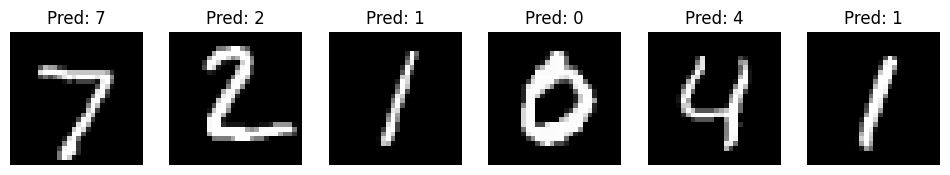

In [34]:
# Step 10: Show sample predictions
def show_predictions(images, preds, n=6):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"Pred: {preds[i]}")
        plt.axis("off")
    plt.show()

show_predictions(all_images, all_preds)